### Directly Loading dataset from kaggle into Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ejlok1/toronto-emotional-speech-set-tess
! unzip toronto-emotional-speech-set-tess

Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional 

### Loading All important packages and modules

In [24]:
import pandas as pd
import numpy as np
import shutil

import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio
import warnings 
warnings.filterwarnings('ignore')

# Shutil.move('Source, destination')
# shutil.move('/content/tess toronto emotional speech set data',"/content/TESS Toronto emotional speech set data")
# shutil.move('/content/TESS Toronto emotional speech set data',"/content/drive/MyDrive/MS THESIS")
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/MS THESIS/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('_')[0][::-1]
        labels.append(label.lower())

df = pd.DataFrame({'speech':paths,'label':labels})
df.sample(5)

,speech,label
140,/content/drive/MyDrive/MS THESIS/TESS Toronto ...,neutral.wav
3644,/content/drive/MyDrive/MS THESIS/TESS Toronto ...,angry.wav
3147,/content/drive/MyDrive/MS THESIS/TESS Toronto ...,fear.wav
2909,/content/drive/MyDrive/MS THESIS/TESS Toronto ...,happy.wav
4451,/content/drive/MyDrive/MS THESIS/TESS Toronto ...,fear.wav


neutral.wav
<class 'str'>


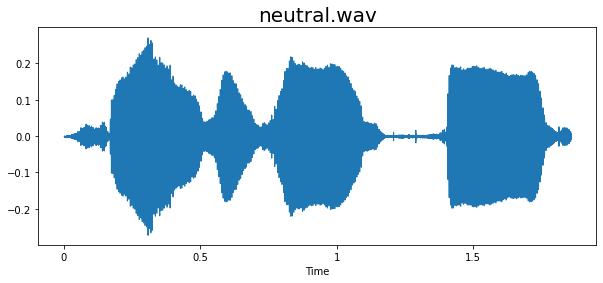

None

disgust.wav
<class 'str'>


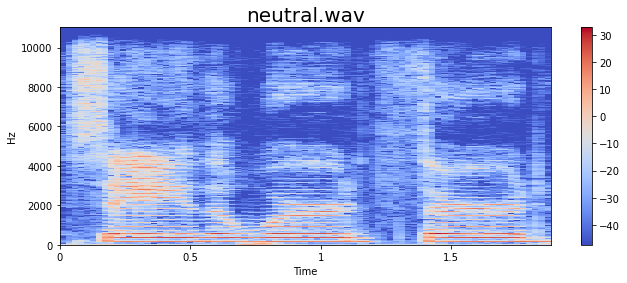

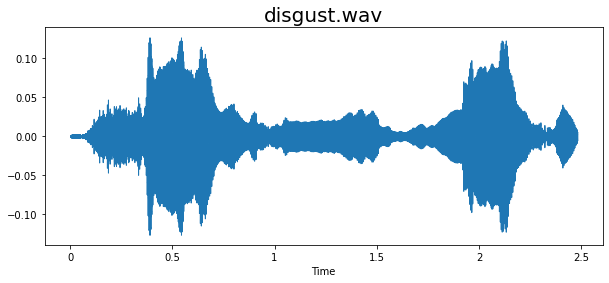

None

sad.wav
<class 'str'>


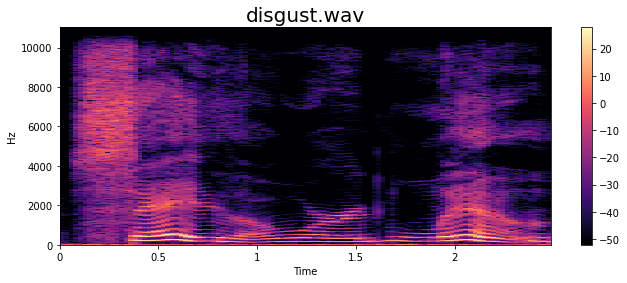

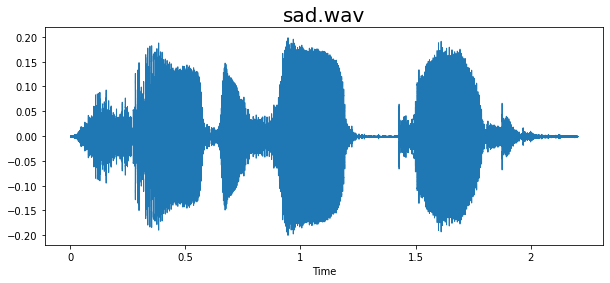

None

happy.wav
<class 'str'>


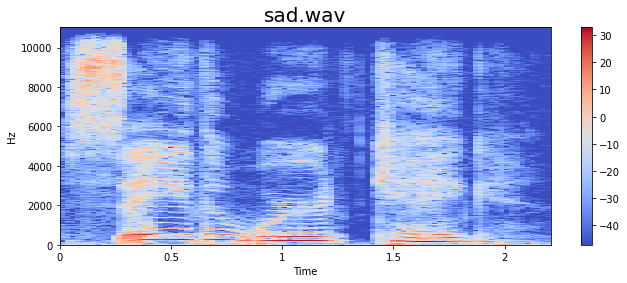

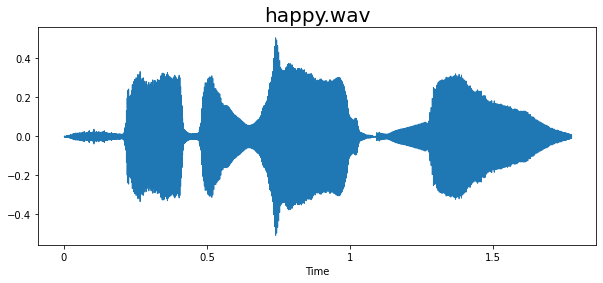

None

fear.wav
<class 'str'>


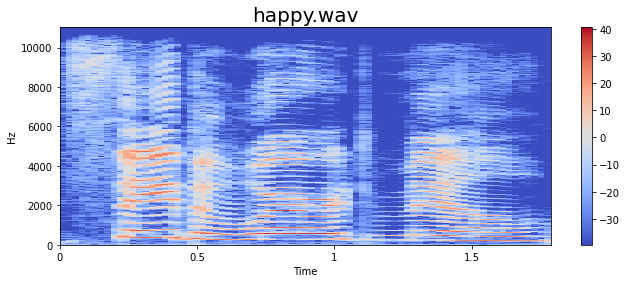

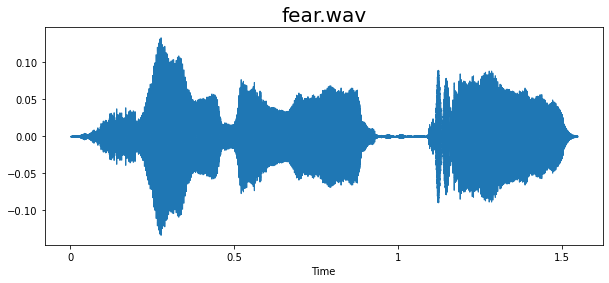

None

angry.wav
<class 'str'>


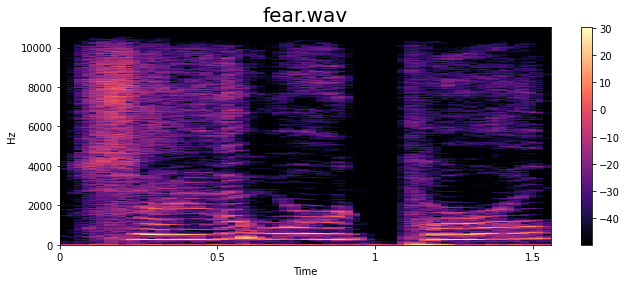

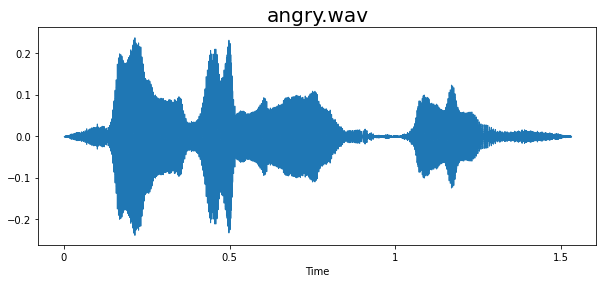

None

ps.wav
<class 'str'>


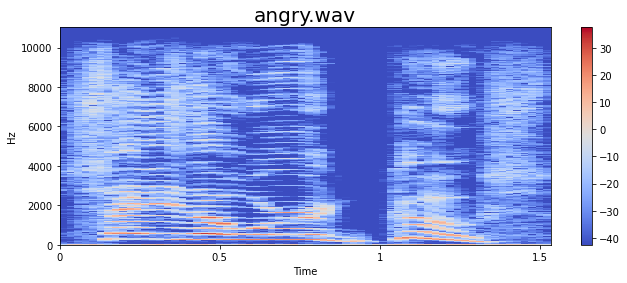

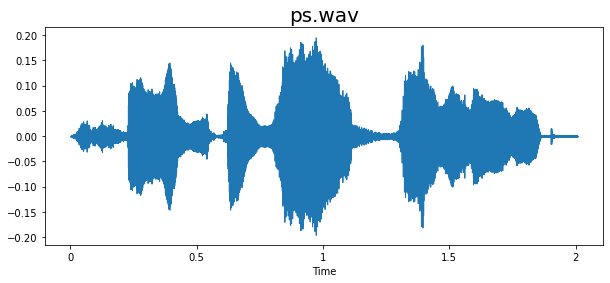

None

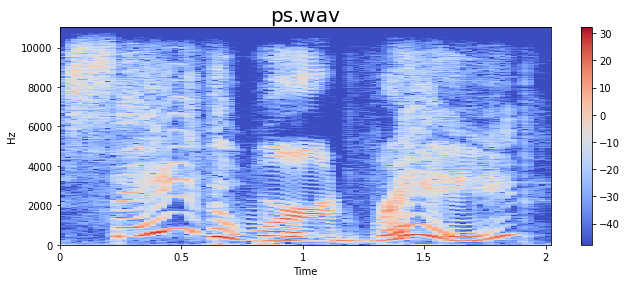

In [4]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

def spectogram(data,sr,emotion):
    x=librosa.stft(data)                 #Short Fourior Transform of Original Data
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()

def ana_emotion(emotion:str, df:pd.DataFrame):
    print(emotion)
    print(str)
    path=np.array(df['speech'][df['label']==emotion])[0]
    data,sampling_rate=librosa.load(path)
    waveplot(data,sampling_rate,emotion)
    spectogram(data,sampling_rate,emotion)
    display(Audio(path))

for i in list(df['label'].unique()):
    display(ana_emotion(i, df))

## Feature Extraction

In [4]:
def extract_features(filename):
    y, sr = librosa.load(filename, sr=None)

    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    energy = np.mean(librosa.feature.rms(y=y))
    pitch, _ = librosa.piptrack(y=y, sr=sr, fmin=75, fmax=1600)
    pitch = np.mean(pitch)

    # Concatenate features into one array
    features = np.concatenate((mfccs, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, zero_crossing_rate, chroma), axis=0)
    features = np.append(features, energy)
    features = np.append(features, pitch)

    return features

# Extract features for all audio files in dataframe
X_features = df['speech'].apply(lambda x:extract_features(x))
X_features_array = np.array(X_features.tolist())

np.save('X_features.npy', X_features_array)
X_features = np.load('X_features.npy',allow_pickle=True)
print('Shape of X_features 2', X_features.shape)
X = np.expand_dims(X_features, -1)

Shape of X_features 2 (5600,)


In [20]:
#shutil.copy('/content/X_features.npy', '/content/drive/MyDrive/MS THESIS/X_features.npy')
X_features = np.load('/content/drive/MyDrive/MS THESIS/X_features.npy',allow_pickle=True)
X = np.expand_dims(X_features, -1)
#print('Data Type = ', X.dtype)
max_len = max(len(x[0]) for x in X)
X_padded = np.zeros((len(X), max_len), dtype=np.float32)
for i, x in enumerate(X):
    X_padded[i, :len(x[0])] = x[0]
X = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], 1)

print('Shape of X', X.shape)
print('Data Type = ', X.dtype)

Shape of X (5600, 10226, 1)
Data Type =  float32


In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
print('Shape of y = ', y.shape)

Shape of y =  (5600, 7)


# Create the LSTM Model

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size =.90)
print('Shape of X = ', X.shape)
print('Shape of Y = ', y.shape)
print('Shape of X_train = ', X_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of X_test = ',  X_test.shape)
print('Shape of Y_test = ', y_test.shape)
# check the type of each array
print("========================")
print('Type of X = ', type(X))
print('Type of Y = ', type(y))
print('Type of X_train = ', type(X_train))
print('Type of y_train = ', type(y_train))
print('Type of X_test = ',  type(X_test))
print('Type of Y_test = ', type(y_test))

Shape of X =  (5600, 10226, 1)
Shape of Y =  (5600, 7)
Shape of X_train =  (5040, 10226, 1)
Shape of y_train =  (5040, 7)
Shape of X_test =  (560, 10226, 1)
Shape of Y_test =  (560, 7)
Type of X =  <class 'numpy.ndarray'>
Type of Y =  <class 'numpy.ndarray'>
Type of X_train =  <class 'numpy.ndarray'>
Type of y_train =  <class 'numpy.ndarray'>
Type of X_test =  <class 'numpy.ndarray'>
Type of Y_test =  <class 'numpy.ndarray'>


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size =.90)

# Reshape data to 2D for scaling
# y = np.argmax(y, axis=1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Create a scaler object and fit on training data
scaler = StandardScaler()
scaler.fit(X_train)

# Transform the training and testing data using the scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the classifiers
svm_clf = make_pipeline(StandardScaler(), SVC())
lr_clf = make_pipeline(StandardScaler(), LogisticRegression())
rf_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
mlp_clf = MLPClassifier()

classifiers = {'SVM': svm_clf, 'Logistic Regression': lr_clf, 'Random Forest': rf_clf, 'KNN' :knn_clf, 'MLP': mlp_clf}

for clf_name, clf in classifiers.items():
    print("Classifier:", clf_name)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    cm = pd.DataFrame(index = [i for i in enc.categories_] , columns = [i for i in enc.categories_])
    print(classification_report(y_test, y_pred))

Classifier: SVM
Accuracy: 0.8714285714285714
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        87
           1       0.98      0.93      0.95        85
           2       0.80      0.85      0.83        67
           3       0.69      0.77      0.73        81
           4       0.95      0.94      0.94        63
           5       0.76      0.77      0.77        88
           6       1.00      0.98      0.99        89

    accuracy                           0.87       560
   macro avg       0.88      0.87      0.87       560
weighted avg       0.88      0.87      0.87       560

Classifier: Logistic Regression
Accuracy: 0.9821428571428571
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        87
           1       1.00      1.00      1.00        85
           2       0.94      0.97      0.96        67
           3       0.98      0.98      0.98        81
           4       1.00   

In [27]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Define model architecture
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(10226, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 10222, 64)         384       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 5111, 64)         0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 5111, 64)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 5107, 128)         41088     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 2553, 128)        0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 2553, 128)        

# Plot the result

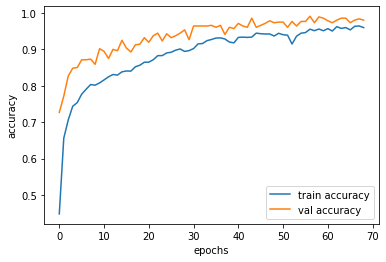

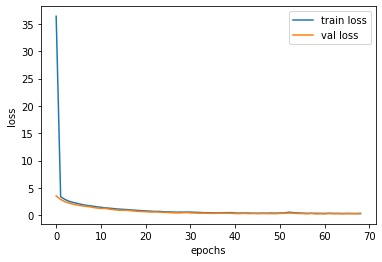

In [28]:
epochs = list(range(69))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
print('Shape of X_test = ',  X_test.shape)
print('Shape of Y_test = ', y_test.shape)
y_pred = model.predict(X_test)
print('Shape of Y_test = ', y_pred.shape)

Shape of X_test =  (560, 10226, 1)
Shape of Y_test =  (560, 7)
18/18 [==============================] - 1s 26ms/step
Shape of Y_test =  (560, 7)


In [30]:
# predicting on test data.
pred_test = model.predict(X_test)
y_pred = enc.inverse_transform(pred_test)
y_test = enc.inverse_transform(y_test)

print(y_pred.shape)
print(y_test.shape)

18/18 [==============================] - 0s 24ms/step
(560, 1)
(560, 1)


In [31]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df

,Predicted Labels,Actual Labels
0,neutral.wav,neutral.wav
1,angry.wav,angry.wav
2,angry.wav,angry.wav
3,happy.wav,happy.wav
4,fear.wav,fear.wav
...,...,...
555,ps.wav,ps.wav
556,ps.wav,ps.wav
557,fear.wav,fear.wav
558,sad.wav,sad.wav


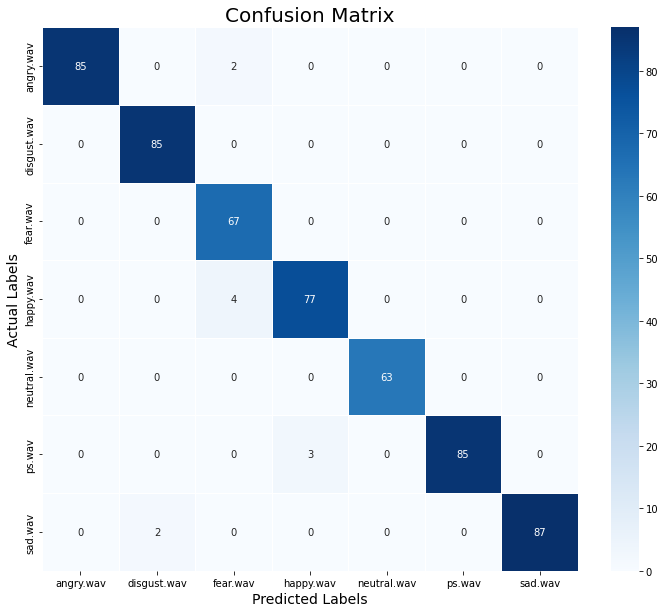

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in enc.categories_] , columns = [i for i in enc.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   angry.wav       1.00      0.98      0.99        87
 disgust.wav       0.98      1.00      0.99        85
    fear.wav       0.92      1.00      0.96        67
   happy.wav       0.96      0.95      0.96        81
 neutral.wav       1.00      1.00      1.00        63
      ps.wav       1.00      0.97      0.98        88
     sad.wav       1.00      0.98      0.99        89

    accuracy                           0.98       560
   macro avg       0.98      0.98      0.98       560
weighted avg       0.98      0.98      0.98       560

